# Artificial Neural Networks and Deep Learning











---











# Homework 1

In [1]:
# Todo (to improve model):

# dropout !!

# Add an edge detection technique on cell images

# Read on past solutions to this problem (papers)

## ⚙️ Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
)
import matplotlib.gridspec as gridspec

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

E0000 00:00:1731324735.443738      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1111 11:32:15.451822935      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1111 11:32:15.451838208      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1111 11:32:15.451841601      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1111 11:32:15.451844007      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1111 11:32:15.451846382      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

## ⏳ Load the Data

In [3]:
# Load Data
# data = np.load('clean_data.npz')
data = np.load("/kaggle/input/clean-data/clean_data.npz")
x = data["images"]
y = data["labels"]
np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8),
 array([ 852, 2181, 1085, 2026,  849,  993, 2330, 1643]))

In [4]:
# Labels dictionary
labels_dict = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Immature granulocytes",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet",
}

In [5]:
class_count = {}

for i in labels_dict:
    class_count[i] = np.unique(y, return_counts=True)[1][i]

class_count

{0: 852, 1: 2181, 2: 1085, 3: 2026, 4: 849, 5: 993, 6: 2330, 7: 1643}

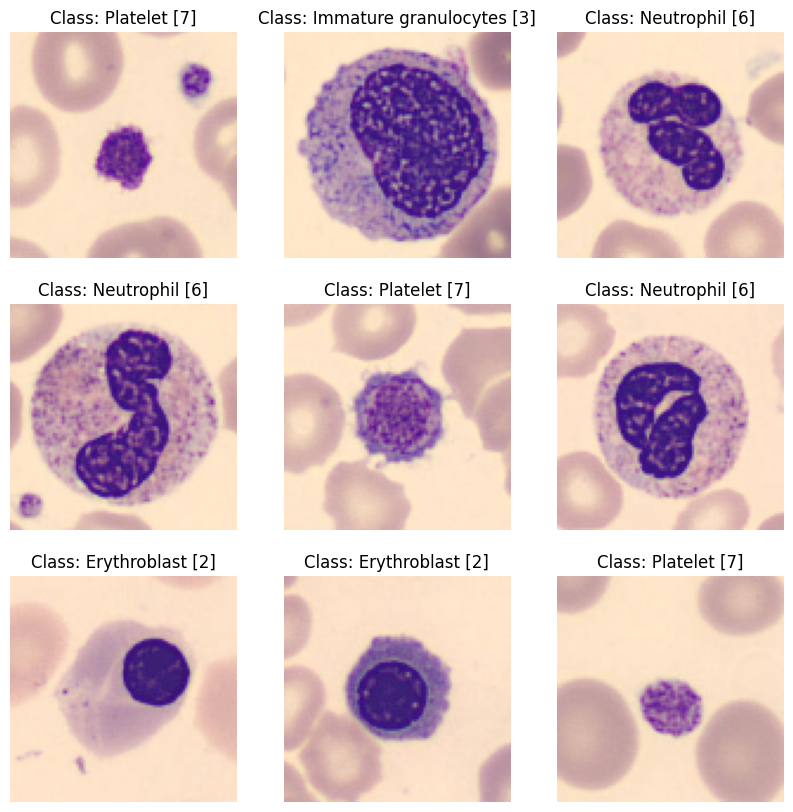

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.reshape((-1,))

for i in range(9):

    axs[i].imshow(x[i])

    axs[i].set_title(f"Class: {labels_dict[y[i][0]]} {y[i]}")

    axs[i].axis("off")

## 🔄 Process Data

In [7]:
# Normalize data to the range [0, 1]
x = (x / 255).astype("float32")

# Convert labels to categorical format using one-hot encoding
y = tfk.utils.to_categorical(y)

In [8]:
test_val_size = 0.05  # parameter to tune

# Split data into train_val and test sets

X_train_val, X_test, y_train_val, y_test = train_test_split(
    x, y, random_state=seed, test_size=test_val_size, stratify=np.argmax(y, axis=1)
)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    random_state=seed,
    test_size=len(X_test),
    stratify=np.argmax(y_train_val, axis=1),
)

# Print shapes of the datasets

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (10763, 96, 96, 3), y_train shape: (10763, 8)
X_val shape: (598, 96, 96, 3), y_val shape: (598, 8)
X_test shape: (598, 96, 96, 3), y_test shape: (598, 8)


## 🧮 Define Network Parameters

In [9]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [10]:
# Number of training epochs
epochs = 100  # parameter to tune

# Batch size for training
batch_size = 32  # parameter to tune

# Learning rate: step size for updating the model's weights
learning_rate = 0.001  # parameter to tune

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)

Epochs: 100
Batch Size: 32
Learning Rate: 0.001


## 🛠️ Build the Model

In [11]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    seed=seed,
):

    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    inputs = tfkl.Input(shape=input_shape, name="Input")
    x = tfkl.Conv2D(filters=32, kernel_size=3, padding="same", name="conv1")(inputs)
    x = tfkl.Activation("relu", name="act1")(x)
    x = tfkl.MaxPooling2D(pool_size=2, name="mp1")(x)
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding="same", name="conv2")(x)
    x = tfkl.Activation("relu", name="act2")(x)
    x = tfkl.MaxPooling2D(pool_size=2, name="mp2")(x)
    x = tfkl.Flatten(name="flatten")(x)
    x = tfkl.Dense(units=output_shape, name="dense")(x)
    outputs = tfkl.Activation("softmax", name="softmax")(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=inputs, outputs=outputs, name="CNN")

    # Compile the model
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ["accuracy"]
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the model
    return model

In [12]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# instantiate a distribution strategy
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = build_model()

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(
    model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70
)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1731324775.729272      13 service.cc:145] XLA service 0x55b155bfb7f0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731324775.729329      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1731324775.729333      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1731324775.729336      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1731324775.729341      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1731324775.729343      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1731324775.729346      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1731324775.729349      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1731324775.729351      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

I0000 00:00:1731324780.165220      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 96, 96, 32)    │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act1 (Activation)           │ (None, 96, 96, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp1 (MaxPooling2D)          │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2 (Conv2D)              │ (None, 48, 48, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act2 (Activation)           │ (None, 48, 48, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp2 (MaxPooling2D)          │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 36864)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 8)             │    294,920 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ softmax (Activation)        │ (None, 8)             │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 314,312 (1.20 MB)

 Trainable params: 314,312 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## 🛠️ Train and Save the Model

In [13]:
# Define the patience value for early stopping
patience = 10

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor="val_accuracy", mode="max", patience=patience, restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [14]:
# Train the model with early stopping callback
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
).history

Epoch 1/100


2024-11-11 11:33:07.292778: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1731324787.525805     831 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ce57a0675f83baa9:0:0), session_name()


 15/337 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2537 - loss: 2.0624

I0000 00:00:1731324789.571866     831 tpu_compile_op_common.cc:245] Compilation of ce57a0675f83baa9:0:0 with session name  took 2.0460104s and succeeded
I0000 00:00:1731324789.576307     831 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ce57a0675f83baa9:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_8814363056076678256", property.function_library_fingerprint = 4598307467196015417, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "4,96,96,3,;4,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1731324789.576347     831 tpu_compilation_cache_interface.cc:541] After adding entry for key ce57a0

336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2830 - loss: 1.8577

I0000 00:00:1731324792.936080     753 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(a78533a89e5e8cac:0:0), session_name()


337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2834 - loss: 1.8567

I0000 00:00:1731324794.717785     753 tpu_compile_op_common.cc:245] Compilation of a78533a89e5e8cac:0:0 with session name  took 1.78167055s and succeeded
I0000 00:00:1731324794.720726     753 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a78533a89e5e8cac:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_8814363056076678256", property.function_library_fingerprint = 4598307467196015417, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;2,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1731324794.720755     753 tpu_compilation_cache_interface.cc:541] After adding entry for key a7853

337/337 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.2838 - loss: 1.8557 - val_accuracy: 0.6800 - val_loss: 0.9879
Epoch 2/100


I0000 00:00:1731324799.363117     774 tpu_compile_op_common.cc:245] Compilation of 20387c6d96acd3ba:0:0 with session name  took 1.142752615s and succeeded
I0000 00:00:1731324799.364185     774 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(20387c6d96acd3ba:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_15605923571912559600", property.function_library_fingerprint = 3881966807585259448, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "3,96,96,3,;3,8,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1731324799.364207     774 tpu_compilation_cache_interface.cc:541] After adding entry for key 203

337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6543 - loss: 1.0253 - val_accuracy: 0.7867 - val_loss: 0.7909
Epoch 3/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6964 - loss: 0.9009 - val_accuracy: 0.8133 - val_loss: 0.7101
Epoch 4/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7169 - loss: 0.8372 - val_accuracy: 0.8267 - val_loss: 0.6396
Epoch 5/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7342 - loss: 0.7921 - val_accuracy: 0.8267 - val_loss: 0.5797
Epoch 6/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7389 - loss: 0.7519 - val_accuracy: 0.8267 - val_loss: 0.5294
Epoch 7/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7646 - loss: 0.7145 - val_accuracy: 0.8267 - val_loss: 0.4885
Epoch 8/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7726 - loss: 0.6814 - val_accuracy: 0.8267 - val_loss: 0.4553
Epoch 9/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7816 - loss: 0.6527 - val_accuracy

ValueError: Device /job:localhost/replica:0/task:0/device:CPU:0 is not found

In [45]:
# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history["val_accuracy"]) * 100, 2)
print(f"Final validation accuracy: {final_val_accuracy}%")

# Save the trained model to a file with the accuracy included in the filename
with tpu_strategy.scope():
    model_filename = "cell.keras"
    model.save(model_filename)
    
    # Delete the model to free up resources
    del model

Final validation accuracy: 88.0%


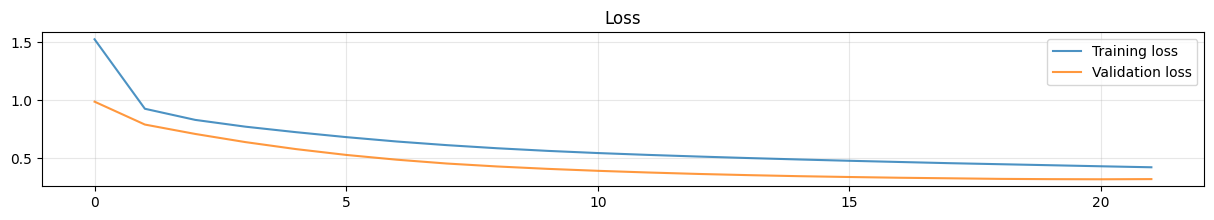

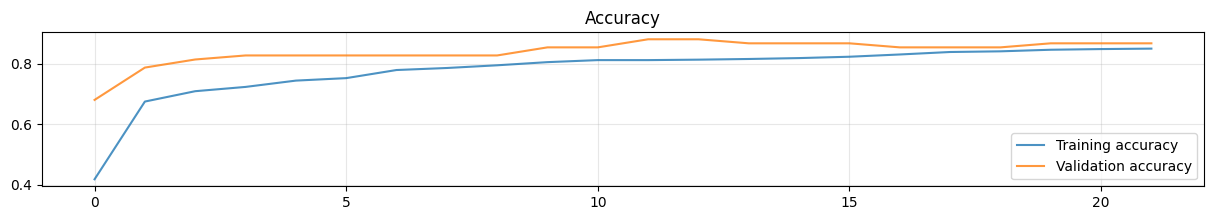

In [46]:
# Plot training and validation loss

plt.figure(figsize=(15, 2))
plt.plot(history["loss"], label="Training loss", alpha=0.8)
plt.plot(history["val_loss"], label="Validation loss", alpha=0.8)
plt.title("Loss")
plt.legend()
plt.grid(alpha=0.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history["accuracy"], label="Training accuracy", alpha=0.8)
plt.plot(history["val_accuracy"], label="Validation accuracy", alpha=0.8)
plt.title("Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model - Make Inference

In [48]:
# Load the saved model

# model = tfk.models.load_model('cell.keras')

model = tfk.models.load_model('/kaggle/working/cell.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv1 (Conv2D)              │ (None, 96, 96, 32)    │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act1 (Activation)           │ (None, 96, 96, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp1 (MaxPooling2D)          │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2 (Conv2D)              │ (None, 48, 48, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ act2 (Activation)           │ (None, 48, 48, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mp2 (MaxPooling2D)          │ (None, 24, 24, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 36864)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 8)             │    294,920 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ softmax (Activation)        │ (None, 8)             │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 942,938 (3.60 MB)

 Trainable params: 314,312 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 628,626 (2.40 MB)

598
Accuracy score over the test set: 0.7993
Precision score over the test set: 0.8085
Recall score over the test set: 0.7993
F1 score over the test set: 0.7884


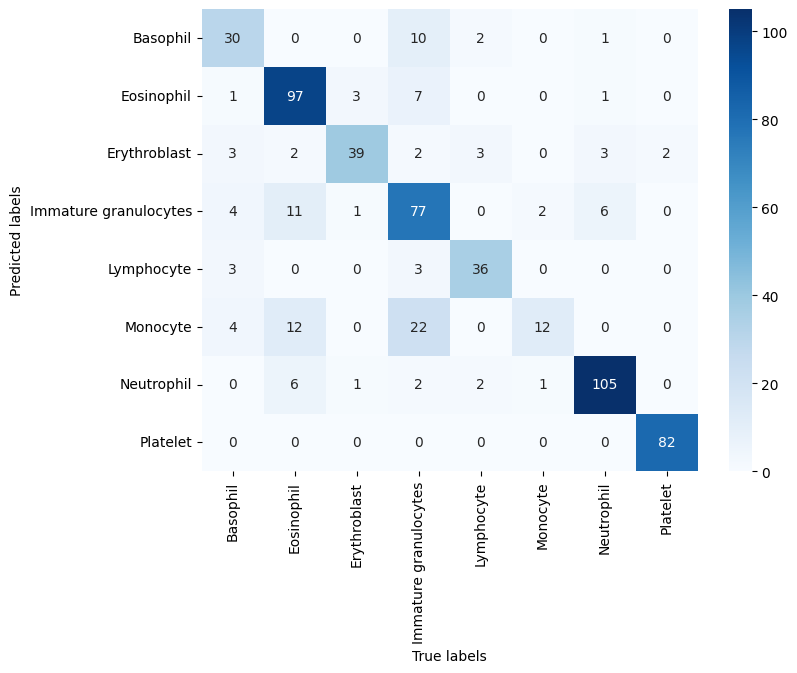

In [49]:
# Predict class probabilities and get predicted classes

test_predictions = model.predict(X_test, verbose=0)
print(len(test_predictions))
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f"Accuracy score over the test set: {round(test_accuracy, 4)}")

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average="weighted")
print(f"Precision score over the test set: {round(test_precision, 4)}")

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average="weighted")
print(f"Recall score over the test set: {round(test_recall, 4)}")

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average="weighted")
print(f"F1 score over the test set: {round(test_f1, 4)}")

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=labels,
    fmt="",
    xticklabels=list(labels_dict.values()),
    yticklabels=list(labels_dict.values()),
    cmap="Blues",
)

plt.xlabel("True labels")
plt.ylabel("Predicted labels")
plt.show()

Text(0.5, 1.0, 'Real label: 2')

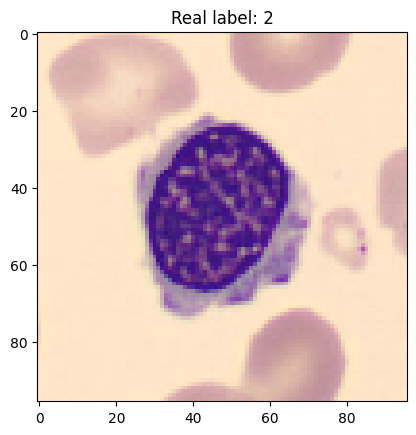

In [50]:
# Let's analyze one specific prediction
test1 = X_test[0]

# show image with real label
plt.imshow(test1*255)
plt.title(f"Real label: {np.argmax(y_test[0])}")

In [51]:
# Reshape the image to match the input shape of the model
test1 = test1.reshape(1, *test1.shape)

print(X_test.shape)
print(test1.shape)

(598, 96, 96, 3)
(1, 96, 96, 3)


In [21]:
test1_pred = model.predict(test1, verbose=0)
print(len(test1_pred))
test1_pred = np.argmax(test_predictions, axis=-1)
print(f"Predicted class: {test1_pred}")
print(f"Real class: {np.argmax(y_test[0])}")

I0000 00:00:1731325000.840748     758 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(30ada7b584e0afa3:0:0), session_name()


1
Predicted class: 3
Real class: 2


I0000 00:00:1731325002.126327     758 tpu_compile_op_common.cc:245] Compilation of 30ada7b584e0afa3:0:0 with session name  took 1.285538326s and succeeded
I0000 00:00:1731325002.127032     758 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(30ada7b584e0afa3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_14546695140619443964", property.function_library_fingerprint = 2530380666863809611, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "2,96,96,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1731325002.127054     758 tpu_compilation_cache_interface.cc:541] After adding entry for key 

In [52]:
len(test_predictions)

598

## 📊 Prepare Your Submission


To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:


```python

# file: model.py

class Model:

    def __init__(self):


        """Initialize the internal state of the model."""


    def predict(self, X):


        """Return a numpy array with the labels corresponding to the input X."""

```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.


❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [53]:
%%writefile model.py

import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:

    def __init__(self):

        """

        Initialize the internal state of the model. Note that the __init__

        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained

        model.

        """

        self.neural_network = tfk.models.load_model('cell.keras')


    def predict(self, X):

        """

        Predict the labels corresponding to the input X. Note that X is a numpy

        array of shape (n_samples, 96, 96, 3) and the output should be a numpy

        array of shape (n_samples,). Therefore, outputs must no be one-hot

        encoded.

        The following is an example of a prediction from the pre-trained model

        loaded in the __init__ method.

        """

        preds = self.neural_network.predict(X, verbose=0)

        # Get the predicted classes, not the one-hot encoded values
        preds = np.argmax(preds, axis=-1)

        return preds

Overwriting model.py


In [54]:
from datetime import datetime

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py cell.keras

# from google.colab import files
# files.download(filename)

/usr/bin/sh: 1: zip: not found


In [55]:
filename

'submission_241111_121715.zip'